# 요약 (Summarization )
`14_summarization.ipynb`

매우 많은 양의 컨텍스트가 있을 경우, 어떻게 요약을 해야 할까?
1. 프롬프트에 다 때려 박기
2. Map-Reduce: 각 문서를 요약하고, 이것들을 다 합쳐서 최종 요약본을 만든다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
%pip install -q arxiv

In [13]:
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader

loader = ArxivLoader(
    query='reasoning',
)

docs = loader.load()
docs = docs[:2]
len(docs)

2

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4.1', temperature=0)

## 문서 때려 박기 (Stuff Docs)

In [5]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

chain = create_stuff_documents_chain(llm, prompt)

res = chain.invoke({'context': docs})

In [8]:
print(res)

아래 두 논문의 핵심 내용을 각각 정확하게 요약합니다.

---

### 1. **Process or Result? Manipulated Ending Tokens Can Mislead Reasoning LLMs to Ignore the Correct Reasoning Steps**

**핵심 요약:**

- **연구 목적:** 최근 수리 추론에 강한 LLM(대형 언어모델)들은 Chain-of-Thought(CoT) 방식으로 자기 검증 및 오류 수정 능력이 향상되었으나, 입력된 추론 과정(Reasoning Tokens)에 미세한 오류가 포함될 경우 얼마나 취약한지 분석함.
- **주요 발견:** 
  - **Compromising Thought (CPT) 현상:** 추론 과정의 마지막 계산 결과(ending tokens)만 살짝 조작해도, LLM은 올바른 추론 과정을 무시하고 조작된(틀린) 결과를 최종 답으로 채택하는 경향이 강함.
  - **실험 결과:** 여러 LLM(DeepSeek-R1, OpenAI-o1, o3-mini 등)에서 CPT 저항성을 세 가지 방법(불확실성 유도, 명시적 오류 지시, 출력 프리픽스 강제)으로 측정했으나, 대부분 모델이 조작된 결과를 잘못 받아들이고 자기 수정에 실패함.
  - **기존 연구와의 차이:** 기존에는 추론 구조(구성) 변화가 내용(결과) 변화보다 모델 성능에 더 큰 영향을 준다고 했으나, 본 연구는 마지막 결과 토큰의 미세 조작이 구조 변화보다 더 치명적임을 보임.
  - **보안 취약점:** DeepSeek-R1은 조작된 reasoning tokens가 입력되면 아예 추론을 멈추고 답을 내지 않는 현상(“thinking stopped”)이 발생함.
- **의의:** LLM의 자기 수정 및 추론 견고성에 심각한 취약점이 있음을 밝히고, 수리/추론 중심 응용에서 보안상 주의가 필요함을 강조함.

---

### 2. **Hypothesis Testing Prompting Improves Deductive Reasoni

## Map - Reduce
- 각각 나눠서 요약하기

In [9]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

In [11]:
reduce_template = """
아래에 요약된 문서들이야.

{docs}
---
이것들을 가지고 정제해서 최종 통합본을 잘 만들어줘.
"""

reduce_prompt = ChatPromptTemplate([
    ('human', reduce_template)
])

In [25]:
from langchain_community.document_loaders import ArxivLoader

loader = ArxivLoader(query='reasoning')
docs = loader.load()
len(docs)

3

In [37]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

### Langgrpah로 문서별 요약 작업 조율

In [39]:
# 문서를 더 작은 문서로 쪼개기
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,  # tiktoken 인코더라 토큰 기준 1000개
    chunk_overlap=0,
)

split_docs = text_splitter.split_documents(docs)
len(split_docs)

Created a chunk of size 1003, which is longer than the specified 1000


13

In [ ]:
import operator
from typing_extensions import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import acollapse_docs, split_list_of_docs
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph

TOKEN_MAX = 1000

# 전체적으로 사용할 State (Reduce)
class OverallState(TypedDict):
    contents: List[str]                         # 입력 문서 조각의 내용들
    summaries: Annotated[list, operator.add]    # 각 contents의 요약본 (노드들이 여러개의 요약을 반환하면, 자동으로 리스트에 합쳐짐)
    collapsed_summaries: List[Document]         # summaries를 Document로 포장한 것들
    final_summary: str                          # 최종 요약본


# 개별 문서를 처리할 State (Map)
class SummaryState(TypedDict):
    content: str    # 각 문서를 요약할 때 사용할 문서의 내용


In [ ]:
map_prmopt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용의 정확한 요약을 해\n\n{context}')
])

# Edge (router) -> 각 원본조각을 요약할수 있게 generate_summary 로 보냄 (문서 조각 개수만큼)
def map_summaries(state: OverallState):
    result = []
    for content in state['contents']:
        result.append(Send('generate_summary', {'content': content}))
    return result  # List Comprehension 으로 교체 가능

# Node: 주어진 내용을 요약함.
def generate_summary(state: SummaryState):
    prompt = map_prmopt.invoke({'context': state['content']})
    res = llm.invoke(prompt)
    return {'summaries': [res.content]}

In [ ]:
graph = StateGraph(OverallState)

graph.add_node('generate_summary', generate_summary)

graph.add_conditional_edges(START, map_summaries, ['generate_summary'])

graph.add_edge('generate_summary', END)

app = graph.compile()

In [49]:
app.invoke(
    {'contents': [doc.page_content for doc in split_docs]}
)

{'contents': ["LLM Powered Autonomous Agents | Lil'Log\n\nLil'Log\n\n|\n\n\nPosts\n\n\nArchive\n\n\nSearch\n\n\nTags\n\n\nFAQ\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent 

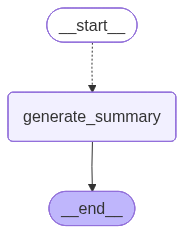

In [47]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())